# CPSC 425 Homework 2

## Scaled Representations, Face Detection and Image Blending

This project is based off the material that is provided by Matthew Brown's course at 
https://mattabrown.github.io/425/assignments/Assignment2.html

The goal here is to expand on the simple gaussian pyramid from earlier by also constructing the Laplacian pyramid which is the high-pass component that is removed when downsampling in image scaling. By preserving this data in a Laplacian pyramid we have the required information to perform a reconstruction



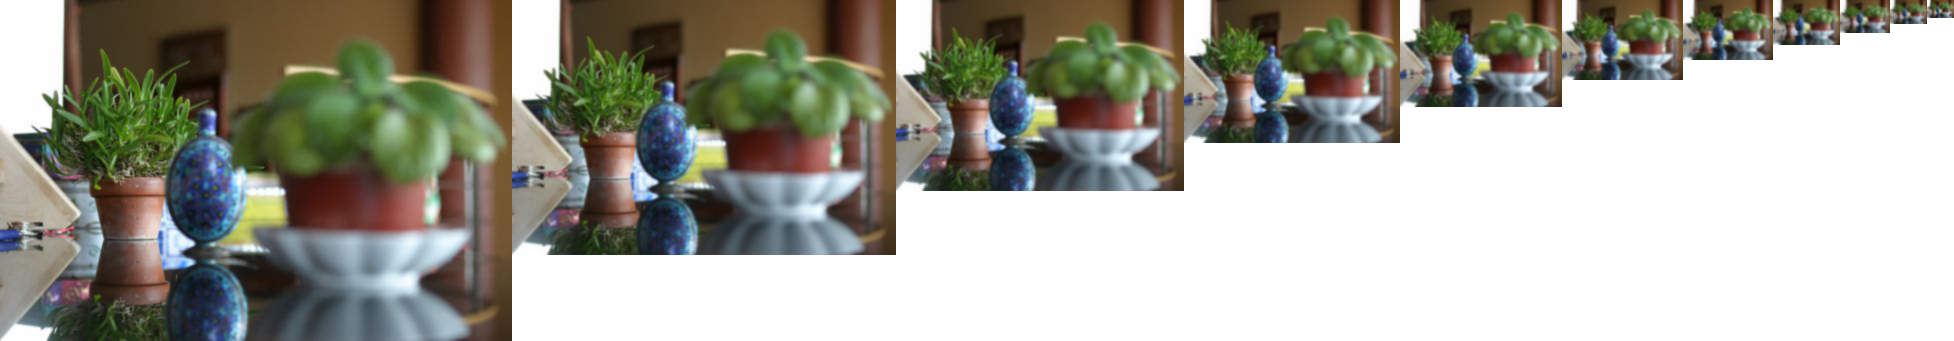

In [285]:
from PIL import Image, ImageDraw
import numpy as np
import math
from scipy import signal
import ncc
import os

from scipy.ndimage import gaussian_filter as gaussfilter

def array_to_image(a):
    """Converts a numpy array to a PIL Image.
    
    Args:
        a: The numpy array to convert.
        
    Returns:
        A PIL Image.

    """
    a = np.clip(a, 0, 255)  # clip to [0,255] to prevent overflows
    return Image.fromarray(np.uint8(a))

def rescale_image(image, scale_factor):
    """Rescale the given PIL Image by the scale factor.

    Args:
        image (PIL.Image): The image to rescale.
        scale_factor (float): The factor to scale the image by.

    Returns:
        PIL.Image: The rescaled image.
    """
    # Calculate the new size
    new_width = int(image.width * scale_factor)
    new_height = int(image.height * scale_factor)
    new_size = (new_width, new_height)

    # Resize the image
    rescaled_image = image.resize(new_size, Image.BICUBIC)

    return rescaled_image

def MakeGaussianPyramid(image, scale, minisize):
    """Creates a Gaussian pyramid of an image.
    Uses a scale factor of 0.75 from one level to the next.
    The pyramid should not go below minisize for the larger size, where minisize is an integer.
    
    Args:
        image: The image to create the pyramid of. Can be RGB or grayscale.
        scale: The factor to scale down by.
        minisize: The minimum size of the pyramid.
        
    Returns:
        A list of images in the pyramid.
        Includes the original PIL image followed by all the images of reduced size.   

    """
    
    # Check for color image
    isColor = image.mode != "L"
    pyramid = []
    sigma = 1 / (2 * scale)
    image = np.asarray(image, dtype='float32')  # Convert PIL Image to numpy array
    pyramid.append(image)  # Append the original image as an array
        
    while image.shape[0] > minisize and image.shape[1] > minisize:
        # Apply a gaussian filter to all channels of the image
        
        if not isColor:
            image = gaussfilter(image, sigma=sigma)
        else:
            for i in range(image.shape[2]):
                image[:, :, i] = gaussfilter(image[:, :, i], sigma=sigma)

        image = rescale(array_to_image(image), scale)  # Convert back to PIL Image for downsampling
        image = np.asarray(image, dtype='float32')  # Convert back to numpy array
        pyramid.append(image)
           
    return pyramid


    
def ShowGaussianPyramid(pyramid):
    """ Presents a Gaussian pyramid as a single image.
    Image is to be laid out as one horizontal strip of images.

    Args:
        pyramid: A list of np arrays, ordered from fine to coarse.
    """
    
    # Check if we have a color image
    array = pyramid[0]
    isColor = len(array.shape) == 3 and array.shape[2] == 3
    
    # collect the widths and heights of each image in the pyramid
    heights = [p.shape[0] for p in pyramid]
    widths = [p.shape[1] for p in pyramid]
       
    # Assign an image type based on the input pyramid
    image_type = "RGB" if isColor else "L"
    # Assign a base color to the image background
    base_color = (255,255,255) if isColor else 255    
    
    # Create a new image that is correct width and height
    image = Image.new(image_type, (sum(widths), max(heights)), color=base_color)
    # Insert the sequence of images in order
    for i in range(len(pyramid)):
        image.paste(array_to_image(pyramid[i]), (sum(widths[:i]), 0))
    
    display(image)
    return image

im = Image.open('imgs/orchid.jpg')
# im = Image.open('tree.jpg')

result = MakeGaussianPyramid(im, 0.75, 20)
im = ShowGaussianPyramid(result) 




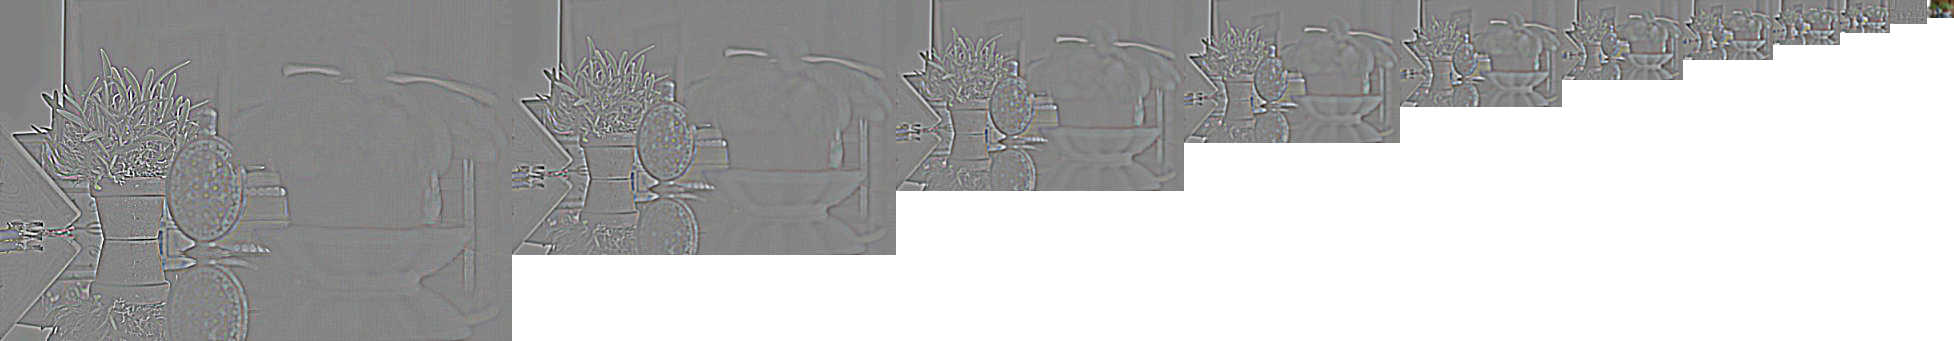

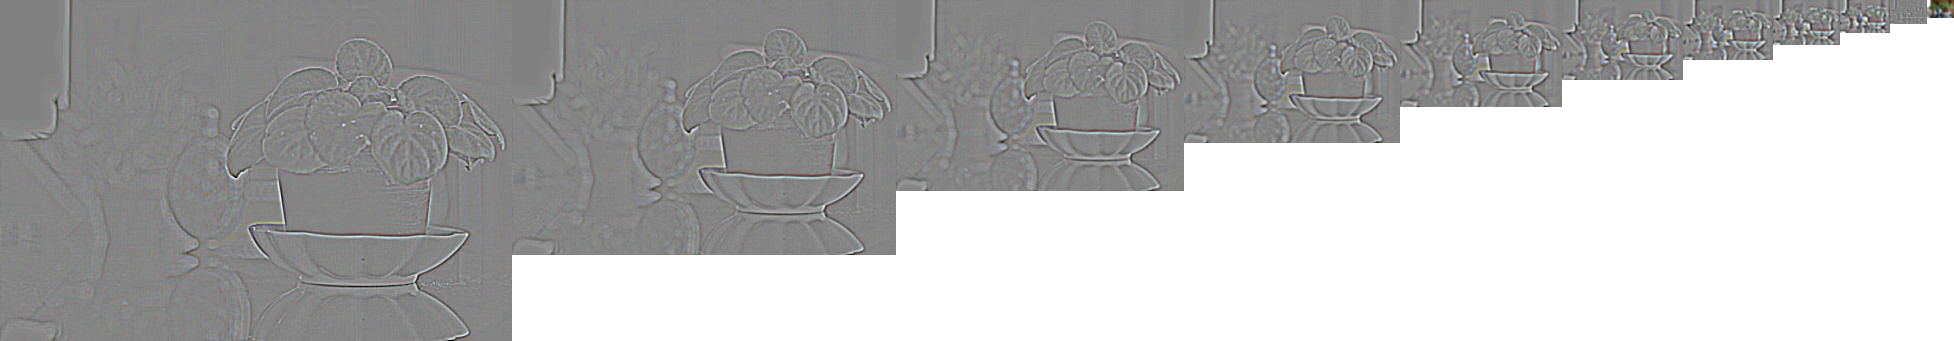

In [286]:
def upsampleImg(image, scale):
    """
    Upsamples an image by a scale factor.
    
    Args:
        image: The image to upsample. Can be RGB or grayscale.
        scale: The factor to scale up by.
        
    Returns:
        The upsampled image as a numpy array.
    """
    
    new_width = int(image.size[0]*scale)
    new_height = int(image.size[1]*scale)
    
    return image.resize((new_width, new_height), Image.BICUBIC)
    
    
def MakeLaplacianPyramid(image, scale, minisize, disp = False):
    """
    Creates a Laplacian pyramid of an image giving both the lowpass and
    high pass filtered images at each level.
    
    Args:
        image: The image to create the pyramid of. Can be RGB or grayscale.
        scale: The factor to scale down by.
        minisize: The minimum size of the pyramid.
        
    Returns:
        A numpy array list of images in the pyramid.
        Includes the original image followed by all the images of reduced size.   
    """
    
    # First create the Gaussian pyramid
    gaussian_pyramid = MakeGaussianPyramid(image, scale, minisize)
    # Create the Laplacian pyramid using the Gaussian pyramid
    # Note: The high pass elemetns are the difference between levels
    #       Perfect reconstruction requires downsample + upsample before subtraction     
    laplacian_pyramid = []
    
    for i in range(len(gaussian_pyramid)-1):
        # Upsample the smaller image to the size of the larger image
        large = array_to_image(gaussian_pyramid[i])
        small = array_to_image(gaussian_pyramid[i+1])      
        zoomed = small.resize(large.size, Image.BICUBIC)
        
        # Subtract the zoomed image from the larger image to get the high pass
        high_pass = gaussian_pyramid[i] - np.asarray(zoomed , dtype='float32')
        laplacian_pyramid.append(high_pass)
            
    # Append the last image in the Gaussian pyramid
    laplacian_pyramid.append(gaussian_pyramid[-1])
    
    return laplacian_pyramid

def ShowLaplacianPyramid(pyramid):
    """ Presents a Gaussian pyramid as a single image.
    Image is to be laid out as one horizontal strip of images.

    Args:
        pyramid: A list of np arrays, ordered from fine to coarse.
    """
    # Make a copy of the pyramid so we don't modify the original
    pyramid = pyramid.copy()
    
    # Check if we have a color image
    array = pyramid[0]
    isColor = len(array.shape) == 3 and array.shape[2] == 3
    
    # collect the widths and heights of each image in the pyramid
    heights = [p.shape[0] for p in pyramid]
    widths = [p.shape[1] for p in pyramid]
       
    # Assign an image type based on the input pyramid
    image_type = "RGB" if isColor else "L"
    # Assign a base color to the image background
    base_color = (255,255,255) if isColor else 255    
    
    # Reprocess the Laplacians for display, they are the last half of the pyramid
    # The final laplacian is identical to gaussian image (no high pass)
    pyramid[:-1] = [np.clip((5*img + 128), 0, 255) for img in pyramid[:-1]]
    
    # Create a new image that is correct width and height
    image = Image.new(image_type, (sum(widths), max(heights)), color=base_color)
    # Insert the sequence of images in order
    for i in range(len(pyramid)):
        # select the next image array in the set
        image_array = pyramid[i]                 
        image.paste(array_to_image(image_array), (sum(widths[:i]), 0))
    
    display(image)
    return image
    
im = Image.open('imgs/orchid.jpg')
imgs = MakeLaplacianPyramid(im, 0.75, 20)
im = ShowLaplacianPyramid(imgs)

im = Image.open('imgs/violet.jpg')
imgs = MakeLaplacianPyramid(im, 0.75, 20)
im = ShowLaplacianPyramid(imgs)
  
    
    

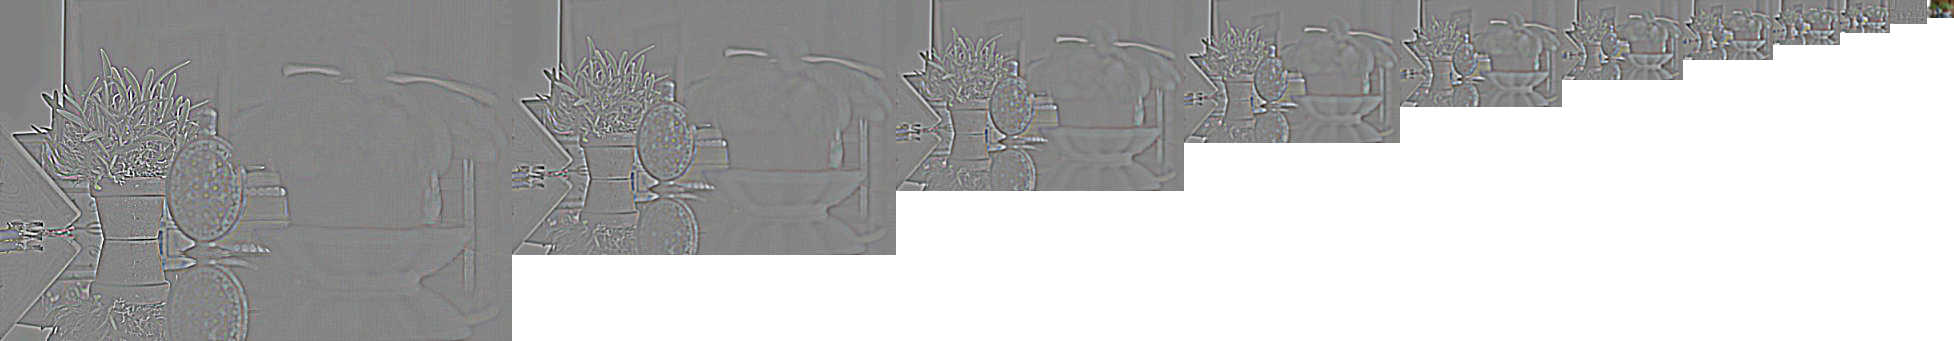

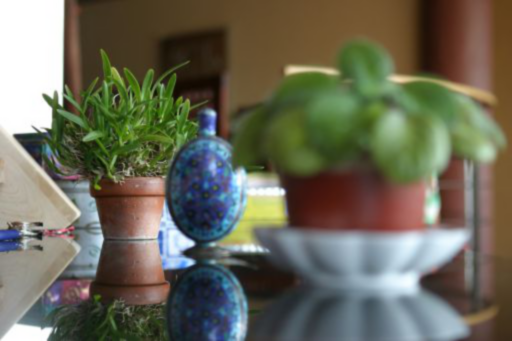

In [287]:
def ReconstructGaussianFromLaplacianPyramid(lpyramid):
    """ Reconstructs an image from its Laplacian Pyramid.
    The image is reconstructed from the top down.
    Each level is upsampled, then added to the next level up.
    The final image is the same size as the original image.
    
    Args:
        lpyramid: The Laplacian pyramid of the image.
        
    Returns:
        The reconstructed image as a numpy array.
    """
    
    # The top of the pyramid is the last element
    # The largest image is the first element
    
    gaussian_image = lpyramid[-1]
    for i in range(len(lpyramid)-2, -1, -1):
        # Upsample the smaller image to the size of the larger image
        large = array_to_image(lpyramid[i])
        small = array_to_image(gaussian_image)      
        zoomed = small.resize(large.size, Image.BICUBIC)        
        
        # Add the enlarged image to the laplacian for reconstruction
        gaussian_image = lpyramid[i] + np.asarray(zoomed, dtype='float32')
                  
    return gaussian_image

im = Image.open('imgs/orchid.jpg')
scale = 0.75
minisize = 20
gaussian  = MakeGaussianPyramid( im, scale, minisize)
laplacian = MakeLaplacianPyramid(im, scale, minisize)
ShowLaplacianPyramid(laplacian)

reconstructed = ReconstructGaussianFromLaplacianPyramid(laplacian)
display(array_to_image(reconstructed))





## Image masking and blending

Now with the available tools designed we work on an image blending task

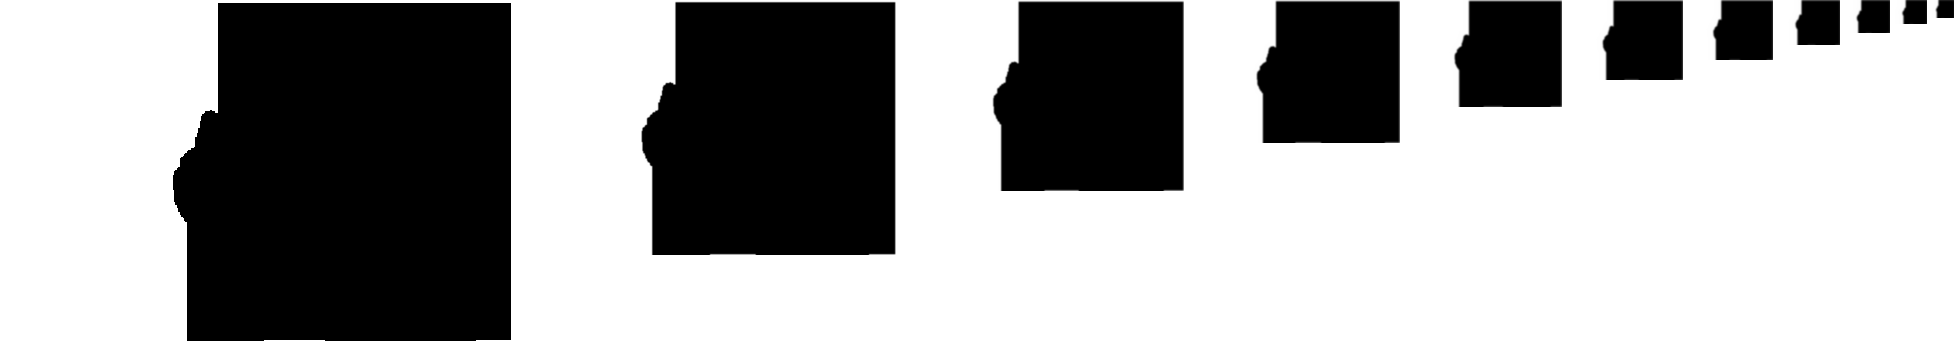

In [288]:
scale = .75
minisize = 20

# Open the mask image and create pyramids
mask = Image.open('imgs/orchid_mask.bmp')
mask_gaussian = MakeGaussianPyramid(mask, scale, minisize)
ShowGaussianPyramid(mask_gaussian)
mask_laplacian = MakeLaplacianPyramid(mask, scale, minisize)


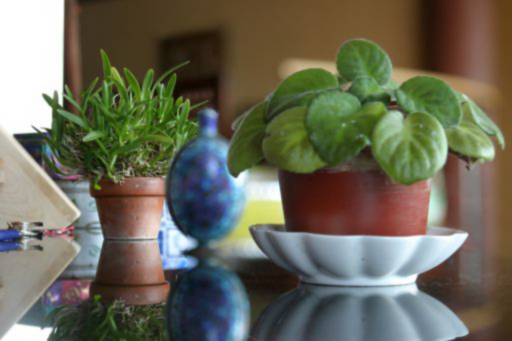

In [289]:
# Define the scale factor and the minimum size for the pyramid
scale = 0.75  
minisize = 20  

# Get the source image laplacian pyramid
image1 = Image.open('imgs/orchid.jpg')
image2 = Image.open('imgs/violet.jpg')
source_images = [image1, image2]

# Create the source image pyramids
source_laplacians = [MakeLaplacianPyramid(img, scale, minisize) for img in source_images]
# Create the mask gaussian pyramid
mask_gaussian = MakeGaussianPyramid(mask, scale, minisize)

# Normalize the mask and convert to color
normalized_mask_gaussian = [(img / 255) for img in mask_gaussian]

# Expand each grayscale mask to RGB by repeating the values across 3 channels
mask_gaussian_rgb = [np.repeat(img[:, :, np.newaxis], 3, axis=2) for img in normalized_mask_gaussian]


def BlendImages(lapA, lapB, mask):
    """ Blends two laplacian pyramids by weighting them according to the mask.
    The mask determines which pixels come from which image.
    The mask is assumed to be the same size as the images.
    The mask should have positive values for image A and negative values for image B.
    
    Args:
        lapA: The laplacian pyramid of the first image.
        lapB: The laplacian pyramid of the second image.
        mask: The gaussian pyramid of the mask.
        
    Returns:
        The blended laplacian pyramid.
    """
        
    blended = []
    for i in range(len(mask)):
        # The blended image at each level is the mask times one image added to
        # one minus the mask times the other image  
        merged_imgs = mask[i]*lapA[i] + (1-mask[i])*lapB[i] 
        blended.append(merged_imgs)   

    composite = ReconstructGaussianFromLaplacianPyramid(blended)
    
    return composite

composite = BlendImages(source_laplacians[0], source_laplacians[1], mask_gaussian_rgb)

display(array_to_image(composite))


## Results

There was some image artefacting happening from the conversion of floating point to unsigned 8-bit integer. The most difficult part of all this imaging processing has been managing the data conversions correctly. As a result, it would be best to build a reliable library of fuctions for converting correctly and as intended between image and mathematical data types.

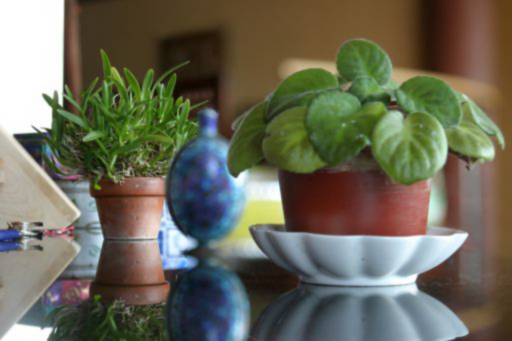

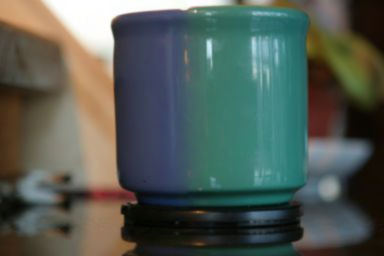

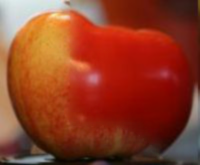

In [290]:
def mergeImages(im1, im2, mask_name):  

    scale = .75
    minisize = 20

    # Open the mask image and create pyramids
    mask = Image.open(mask_name)
    # Create the mask gaussian pyramid
    mask_gaussian = MakeGaussianPyramid(mask, scale, minisize)
    # Normalize the mask and convert to color
    normalized_mask_gaussian = [(img / 255) for img in mask_gaussian]
    # Expand each grayscale mask to RGB by repeating the values across 3 channels
    mask_gaussian_rgb = [np.repeat(img[:, :, np.newaxis], 3, axis=2) for img in normalized_mask_gaussian]

    # Get the source image laplacian pyramid
    image1 = Image.open(im1)
    image2 = Image.open(im2)
    source_images = [image1, image2]

    # Create the source image pyramids
    source_laplacians = [MakeLaplacianPyramid(img, scale, minisize) for img in source_images]

    composite = BlendImages(source_laplacians[0], source_laplacians[1], mask_gaussian_rgb)
    display(array_to_image(composite))
    
mergeImages('imgs/orchid.jpg', 'imgs/violet.jpg', 'imgs/orchid_mask.bmp')
mergeImages('imgs/blue_cup.jpg', 'imgs/green_cup.jpg', 'imgs/cup_mask.bmp')
mergeImages('imgs/tomato.jpg',    'imgs/tomato_mask.bmp')